# Model 2: High resolution prediction of flood maps

The output of this model is used to measure global performance the performance of the pipeline.

**The last section of this notebook create a submission file for the challenge**

In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import src.baseline_model02 as bm
import shutil

# Training

The next cell allows you to quickly test models by reducing the amount of data used.

*nb_train_minicube*, *nb_test_minicube* and *nb_val_minicube*, are used to limit the number of "mini data cube" used in train/test/val sets and therefore reduce the computational cost of the training and hyper parameters exploration. With also only keep minicubes above the *min_score_model1* threshold.

If you choose a high number of minicubes, the threshold should be low enough.


In [9]:
baseline_model_generator_test = bm.BaseLineModel(
    "localdata/smallbox/label/label_",
    train_start = "2002-08-03",  # date where to split train test
    train_end = "2003-03-17",  # date where to split train test
    dynamic_features_path = "localdata/Model1_score_ERA5_Rez_v2.nc",
    static_features_root_path = "localdata/smallbox/static/static_",
    dynamic_features_FR_path = "localdata/Model1_Score_Full_Rez_v2.nc",
    inf_dynamic_features_FR_path = "localdata/Model1_Score_Full_Rez_inf.nc",
    static_features_FR_path = "localdata/static_Full_Rez.nc",
    labels_ERA5_path = "localdata/final_label_Full_ERA5.nc",
    labels_FR_path = "localdata/final_label_Full_Rez.nc",
    nb_train_minicube = 200, #Those values are very small for good performance you will need more datacubes
    nb_test_minicube = 50,  #Those values are very small for apropriate test you will need more datacubes
    nb_val_minicube = 50,
    min_score_model1 = 0.2,
    name="Baseline_Model_2_Small_20_02",
    seed=1
    )

### Preparation of the train / test / val dataset

When using a high number of minicubes or low threshold, this process can still be quite long. The vectorised train / test / val can be saved to gain time when training several models on the same data.

In [10]:
baseline_model_generator_test.prepare_data()

# TP train : 826
# FP train : 1118
# TP test : 818
# FP test : 1052
# TP val : 406
# FP val : 1464


### Training

Training a Logistic Regression model with Max_iter= 100

In [11]:
baseline_model_generator_test.train_model([False, #True, #soilgrid_bdod
                                          False, #soilgrid_cfvo
                                          False, #True, #soilgrid_silt
                                          True, #soilgrid_clay
                                          False, #True, #soilgrid_sand
                                          False, #True, #depth_to_bedrock
                                          True, #altitude
                                          False, #True, #aspect
                                          True, #slope
                                          True, #True, #water_density
                                          False, #watershed
                                          False, #True, #topological_catchment_areas
                                          False, #dist_sea
                                          True, #dist_riv
                                          True, #M1_score
                                          160,
                                          4],
                                          compute_xval = False) # Set to true to get the X-Val score (AUC-ROC by default)

0.9966272391120762

### Geographical results

##### Prediction score Map

##### False Positive, True Positive, False Negative Mapping

In [12]:
baseline_model_generator_test.load_FullRez()

In [ ]:
# baseline_model_generator_test.print_TNTPFN(save_path="graph/model2/TNTPFN/", thresholdM1=0.5, thresholdM2=0.5)

In [ ]:
# baseline_model_generator_test.print_proba(save_path="graph/model2/Proba/", thresholdM1=0.5, thresholdM2=0.5)

In [ ]:
# baseline_model_generator_test.print_proba(save_path="graph/model2/ProbaReduced/", 
#                                           thresholdM1=0.5, 
#                                           thresholdM2=0.5,
#                                           min_x=3500,
#                                           min_y=2500)

### Performance analysis

### Pre-processing of the full test data

Loading of the Full Test Dataset from disk.
The vectorised Full train test (all France data on the define time slices for test train might be quite long to process).
Furthermore the *Full test set*, by nature, is fixed, so we process the vectorised *Full Test Set* independently.
When you have done this process one time you don't need to do it again as long as you don't change your first model outputs.

In [13]:
baseline_model_generator_test.prepare_data(compute_full_test_set=True ) #This will take a while, only do it one time

# TP test : 0
# FP test : 1944


#### ROC plots

Full_Test


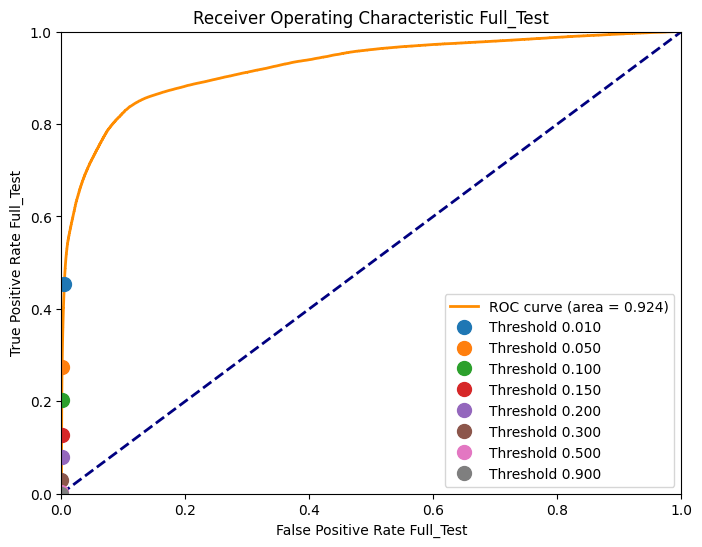

In [20]:
 # baseline_model_generator_test.auc_graph("Full_Test", "", [0.01,0.05,0.1,0.15, 0.2,0.3, 0.5, 0.9])


In [15]:
 # baseline_model_generator_test.process_AUC_metrics(filter=False)

roc
roc : 0.9244088016199732
AP
AP : 0.07247936103365916
BrierScore
BrierScore : 0.0005570912823702928


# Computation of predictions for codabench

#### Data loading

In [16]:
baseline_model_generator_test.load_InfRez()

saving predictions

In [17]:
baseline_model_generator_test.save_full_pred()

(9, 3936, 5953)


# Part 4 submission

# Model 2: High resolution prediction of flood maps

Loading of the previously computed predictions

In [21]:
predictions = xr.open_dataset("localdata/Model2_Score_Full_Rez_inf.nc")

In [22]:
relevent_data_tag_binary_mask = xr.open_dataset("localdata/raw/relevent_data_tag_binary_mask.nc")

nan_mask = relevent_data_tag_binary_mask["__xarray_dataarray_variable__"] == 1
data_array = predictions["M2_score"]

for time in predictions.time.values:
    time_slice = data_array.sel(time=time)
    time_slice = time_slice.where(~nan_mask, -1)
    data_array.loc[dict(time=time)] = time_slice

predictions["M2_score"] = data_array
predictions.to_netcdf(f'localdata/predictions_tmp.nc', engine='h5netcdf')


In [23]:
np.unique(predictions["M2_score"].values)

array([-1.00000000e+00,  1.10505535e-10,  1.74784257e-10, ...,
        6.41048968e-01,  6.41102016e-01,  6.44476712e-01], dtype=float32)

In [24]:
def from_xarray_to_vector(data: xr.DataArray):
    data = data.sortby("time").sortby("x").sortby("y")

    xry = data.M2_score.values
    vectors = xry.reshape(xry.shape[0], xry.shape[1]*xry.shape[2])
    vector = vectors.flatten()
    mask = vector == -1
    return vector[~mask]

**The submission file should be a flatten vector**

Conversion to vector

In [25]:
out = from_xarray_to_vector(predictions)

Sanity check

In [26]:
len(out) # it should be 112923207

112923207

In [ ]:
# pd.DataFrame(out).to_csv("localdata/pred.csv")
# shutil.make_archive("localdata/pred.csv", 'zip', "localdata","pred.csv")